<a href="https://colab.research.google.com/github/Taehee-K/Brain-Tumor-Classification/blob/main/code/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
path = os.path.dirname(os.path.abspath(__file__))
os.chdir(path)

# Split Data

* Train, Validation, Test 데이터 폴더 나누기

In [ ]:
import shutil
 
original_dataset_dir = './BrainTumorData'   
classes_list = os.listdir(original_dataset_dir) 
 
base_dir = './splitted'                           # train-validation 데이터 나누어 저장
os.mkdir(base_dir)
 
train_dir = os.path.join(base_dir, 'train')       # train data
os.mkdir(train_dir)
test_dir = os.path.join(base_dir, 'val')          # test data
os.mkdir(test_dir)

for cls in classes_list:     
    os.mkdir(os.path.join(train_dir, cls))
    os.mkdir(os.path.join(test_dir, cls))

* Train:Test 8:2 로 데이터 분할
* 각 클래스 별 데이터 수 확인

In [ ]:
import math
 
for cls in classes_list:
    path = os.path.join(original_dataset_dir, cls)
    fnames = os.listdir(path)
 
    train_size = math.floor(len(fnames) * 0.8)
    test_size = math.floor(len(fnames) * 0.2)
    
    train_fnames = fnames[:train_size]
    print("Train size(",cls,"): ", len(train_fnames))
    for fname in train_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    test_fnames = fnames[train_size:]
    print("Test size(",cls,"): ", len(test_fnames))
    for fname in test_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(test_dir, cls), fname)
        shutil.copyfile(src, dst)

Train size( Brain Tumor ):  2010
Test size( Brain Tumor ):  503
Train size( Healthy ):  1669
Test size( Healthy ):  418


# Import Modules

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Data
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 
from torch.utils.data import DataLoader

# Pytorch --> MLP, CNN
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary

In [4]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [5]:
BATCH_SIZE = 64
EPOCH = 30

In [6]:
original_dataset_dir = './BrainTumorData'   
classes_list = os.listdir(original_dataset_dir) 

n_classes = len(classes_list)
print(classes_list)           # 분류해야 할 클래스들
print(n_classes)      # 클래스 수 2개

['Brain Tumor', 'Healthy']
2


# Load Data

In [7]:
transform_base = transforms.Compose([transforms.Resize((227,227)),
                                     transforms.ToTensor(),
                                     transforms.Grayscale(num_output_channels=1)]) 
train_dataset = ImageFolder(root='./splitted/train', transform=transform_base)
test_dataset = ImageFolder(root='./splitted/val', transform=transform_base)

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


* 데이터 개수, 형태 확인

In [9]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(),'type:', X_train.type())
    print('y_train:', y_train.size(),'type:', y_train.type())
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


X_train: torch.Size([64, 1, 227, 227]) type: torch.FloatTensor
y_train: torch.Size([64]) type: torch.LongTensor


In [10]:
for (X_test, y_test) in train_loader:
    print('X_test:', X_test.size(),'type:', X_test.type())
    print('y_test:', y_test.size(),'type:', y_test.type())
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


X_test: torch.Size([64, 1, 227, 227]) type: torch.FloatTensor
y_test: torch.Size([64]) type: torch.LongTensor


* 데이터 사진 확인하기

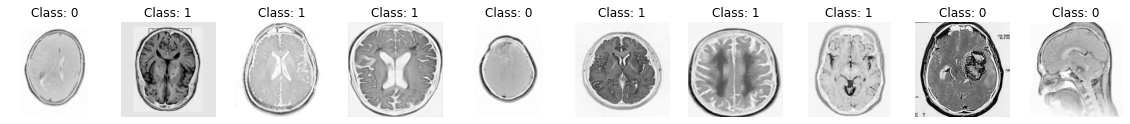

In [11]:
pltsize = 2
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(227, 227), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

# Multi-Layer Perceptron



* MLP


![mlp](https://koalaverse.github.io/machine-learning-in-R/images/mlp_network.png)

In [12]:
class MLP(nn.Module): # MLP 모델 설계
    def __init__(self, n_classes = 2):   
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(227*227, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 2)

    def forward(self, x):
        x = x.view(-1, 227*227*1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        x = F.log_softmax(x, dim=1)
        
        return x

# print model summary
mlp = MLP().to(DEVICE)
summary(mlp, (1, 227, 227)) # summary code 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]      26,383,360
            Linear-2                  [-1, 256]         131,328
            Linear-3                    [-1, 2]             514
Total params: 26,515,202
Trainable params: 26,515,202
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.20
Forward/backward pass size (MB): 0.01
Params size (MB): 101.15
Estimated Total Size (MB): 101.35
----------------------------------------------------------------


In [13]:
optimizer = optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

* Train Model

In [14]:
def train(model, train_loader, optimizer):
    model.train()                         # 모델 train 상태로
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)  # data, target 값 DEVICE에 할당
        optimizer.zero_grad()                              # optimizer gradient 값 초기화
        output = model(data)                               # 할당된 데이터로 output 계산
        loss =  criterion(output, target)                  # Cross Entropy Loss 사용해 loss 계산
        loss.backward()                                    # 계산된 loss back propagation
        optimizer.step()                                   # parameter update

* Evaluate Model

In [15]:
def evaluate(model, test_loader):
    model.eval()      # 모델 평가 상태로
    test_loss = 0     # test_loss 초기화
    correct = 0       # 맞게 예측한 0 값으로 초기화
    
    with torch.no_grad(): 
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)     # data, target DEVICE에 할당
            output = model(data)                                  # output 계산
            test_loss += criterion(output, target).item()         # loss 계산(총 loss 에 더해주기)
            pred = output.max(1, keepdim=True)[1]                 # 계산된 벡터값 중 가장 큰 값 가지는 class 예측
            correct += pred.eq(target.view_as(pred)).sum().item() # 맞게 예측한 값 세기
   
    test_loss /= len(test_loader.dataset)                         # 평균 loss
    test_accuracy = 100. * correct / len(test_loader.dataset)     # test(validation) 데이터 정확도
    return test_loss, test_accuracy 

## Train MLP

In [17]:
import time
import copy
 
def train_model(model ,train_loader, val_loader, optimizer, num_epochs = 30):
    best_acc = 0.0  # beset accuracy 초기화
    best_model_wts = copy.deepcopy(model.state_dict()) 
 
    for epoch in range(1, num_epochs + 1):
        since = time.time()                                     # 학습 시간 계산
        train(model, train_loader, optimizer)                   # train 데이터로 학습
        train_loss, train_acc = evaluate(model, train_loader)   # train_loss, train_acc 계산
        val_loss, val_acc = evaluate(model, val_loader)         # valid_loss, valid_acc 계산
        
        if val_acc>best_acc:  # update best accuracy
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        time_elapsed = time.time() - since # 학습 시간 출력
        print('-------------- epoch {} ----------------'.format(epoch))
        print('train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))   
        print('val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 

    model.load_state_dict(best_model_wts)  
    return model

model = train_model(mlp ,train_loader, test_loader, optimizer)  	# 모델 학습시키기
torch.save(model,'MLP.pt') 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


-------------- epoch 1 ----------------
train Loss: 0.0086, Accuracy: 75.78%
val Loss: 0.0080, Accuracy: 78.28%
Completed in 6m 8s
-------------- epoch 2 ----------------
train Loss: 0.0076, Accuracy: 80.57%
val Loss: 0.0069, Accuracy: 82.52%
Completed in 0m 34s
-------------- epoch 3 ----------------
train Loss: 0.0063, Accuracy: 82.11%
val Loss: 0.0061, Accuracy: 82.41%
Completed in 0m 34s
-------------- epoch 4 ----------------
train Loss: 0.0038, Accuracy: 92.80%
val Loss: 0.0047, Accuracy: 89.36%
Completed in 0m 34s
-------------- epoch 5 ----------------
train Loss: 0.0063, Accuracy: 80.54%
val Loss: 0.0058, Accuracy: 81.32%
Completed in 0m 34s
-------------- epoch 6 ----------------
train Loss: 0.0030, Accuracy: 93.37%
val Loss: 0.0043, Accuracy: 89.58%
Completed in 0m 34s
-------------- epoch 7 ----------------
train Loss: 0.0036, Accuracy: 90.98%
val Loss: 0.0072, Accuracy: 81.98%
Completed in 0m 34s
-------------- epoch 8 ----------------
train Loss: 0.0012, Accuracy: 97.28%


## Test MLP

In [18]:
model=torch.load('MLP.pt')
model.eval()
loss, acc = evaluate(model, test_loader)

print('Test Accuracy: {:.4f}'.format(acc))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Accuracy: 99.3485


In [19]:
from sklearn.metrics import classification_report

def prediction(model, data_loader):
    model.eval()
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    
    with torch.no_grad():
      for i, (data, label) in enumerate(test_loader):
        data = data.to(DEVICE)        # 데이터 DEVICE에 할당
        label = label.to(DEVICE)      # 라벨 값 DEVICE에 할당
        outputs = model(data)         # 예측
        _, preds = torch.max(outputs, 1)  # 가장 높은 확률 가지는 class 예측

        # Batch 단위 예측값 append 하기
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,label.view(-1).cpu()])
        
    # Classification Report
    print(classification_report(lbllist.numpy(), predlist.numpy())) # 클래스별 accuracy, recall, f1-score 
    return 

In [20]:
prediction(model, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99       503
           1       0.99      1.00      0.99       418

    accuracy                           0.99       921
   macro avg       0.99      0.99      0.99       921
weighted avg       0.99      0.99      0.99       921

